In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEpIuouD9yQlbrZ9tosomJf1LJUjkX3k2ygGC7F_9FecnYI8rFcn_4
Mounted at /content/drive


In [2]:
import tarfile
import os

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/relu'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_relu.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/relu')

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/logistic'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_logistic.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/logistic')


In [3]:
# an example dataframe, note the repeated formulas
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/UFRGS/Learnability/logistic/neurons_logistic_v50_over_v50_c238_r4.760.csv')
df.head(4)

,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,1,5,accuracy,0.809424,0.233407,2020-08-28 11:31:28.548645,2020-08-28 11:31:29.442348
1,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,2,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:30.320994
2,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,4,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:31.254835
3,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.000000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640


In [4]:
# then we get the maximum #neurons of each formula (no repeated formulas anymore)
# note that none of those with 512 neurons has perfect accuracy
grouped_df = df.groupby("formula", sort=False, as_index=False).last()
print(len(grouped_df))
grouped_df.head(4)

173


,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640
1,sat_00009_k3_v50_c238.cnf_unigen_100_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:32.804739,2020-08-28 11:31:35.884857
2,sat_00054_k3_v50_c238.cnf_unigen_54_500.pkl.gz,unigen,logistic,16,5,accuracy,1.00000,0.000000,2020-08-28 11:31:35.884958,2020-08-28 11:31:40.083207
3,sat_00102_k3_v50_c238.cnf_unigen_316_500.pkl.gz,unigen,logistic,512,5,accuracy,0.99878,0.002439,2020-08-28 11:31:40.083311,2020-08-28 11:32:03.657900


In [5]:
import numpy as np

df2 = df.where(df.sampler=='unigen').groupby('formula', sort=False, as_index=False).last()['#neurons'].value_counts(normalize=True,sort=False)
x = df2.index[np.argsort(df2.index)]
y = df2.values[np.argsort(df2.index)]

In [6]:
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns;

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


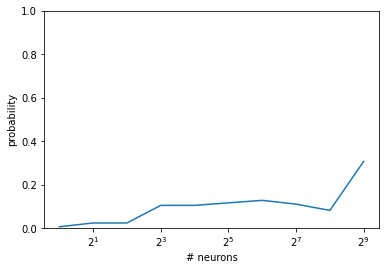

In [7]:
ax = sns.lineplot(x=x,y=y,markers=x)
from matplotlib.ticker import FixedLocator, PercentFormatter
xp = FixedLocator(x)
plt.gca().xaxis.set_major_locator(xp)
ax.set_ylim([0,1])
ax.set_xscale('log', basex=2)
ax.set_xlabel('# neurons')
ax.set_ylabel('probability')
ax;

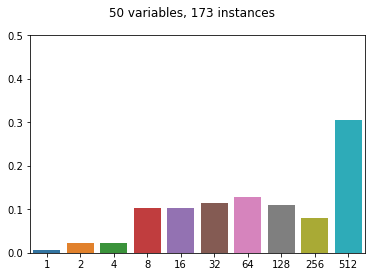

In [8]:
ax = sns.barplot(x=x,y=y)
plt.suptitle(f'50 variables, {len(grouped_df)} instances')
ax.set_ylim([0,.5])
ax;

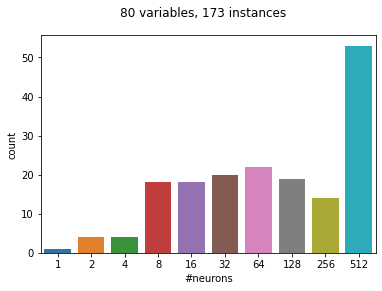

In [9]:
# now, I'll plot a count of how many formulas were mastered with each number of neurons
plt.figure()
sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
plt.suptitle(f'80 variables, {len(grouped_df)} instances')
pass # holds the output of suptitle

In [10]:
base_dir = '/content/drive/My Drive/UFRGS/Learnability'

In [41]:
from glob import glob
import os
import re
from tqdm import tqdm

def dir_string_ratio(dir_str):
    """
    Extracts the ratio on a directory string.
    Useful for sorting in increasing difficulty
    """
    reg = extract_vars_from_path(os.path.basename(dir_str))

    # pattern = re.compile(r"r(\d\.\d+)\.csv")

    # return float(pattern.search(dir_str).group(1))
    key_activation = 0 if reg['activation'] == 'relu' else 1
  
    return (key_activation, int(reg['vars']), reg['ratio'])

def extract_vars_from_path(input):
  regex = r'neurons_(\w+)_v(\d+)_(\w+)_v\d+_c(\d+)_r(\d\.\d+)\.csv'
  pattern = re.compile(regex)
  activation, n_vars, pos, c, r = pattern.search(input).groups()
  return dict(activation=activation, vars=str(n_vars), phase=pos, clauses=int(c), ratio=float(r))

all_data = []  

for i, f in enumerate(tqdm(sorted(glob(f'{base_dir}/**/*.csv',recursive=True), key=dir_string_ratio))):
  reg = extract_vars_from_path(os.path.basename(f))
 
  df = pd.read_csv(f)
  grouped_df = df.where(df.sampler=='unigen').groupby(['formula','activation'], as_index=False).last().reset_index()
  filtered_df = grouped_df[grouped_df['#neurons'] < 512]
  ratio_learned = len(filtered_df) / len(grouped_df)

  reg['constrainedness'] = -5+np.mod(i,11)
  reg['learned'] = ratio_learned
  reg['mean_neurons'] = np.mean(filtered_df['#neurons'])
  reg['sd_neurons'] = np.std(filtered_df['#neurons'])
  
  all_data.append(reg)

dt_out = pd.DataFrame.from_dict(all_data)

100%|██████████| 220/220 [00:07<00:00, 28.28it/s]


In [90]:
dt_out.to_pickle(f'{base_dir}/probabilities.pkl')
dt_out.to_csv('/content/drive/My Drive/UFRGS/probabilities.csv',index_label=False)
dt_out.head()

,activation,vars,phase,clauses,ratio,constrainedness,learned,mean_neurons,sd_neurons,nvars
0,relu,10,under,50,5.0,-5,0.0,NaN,NaN,10
1,relu,10,under,51,5.1,-4,0.0,NaN,NaN,10
2,relu,10,under,52,5.2,-3,0.0,NaN,NaN,10
3,relu,10,under,53,5.3,-2,0.0,NaN,NaN,10
4,relu,10,under,54,5.4,-1,0.0,NaN,NaN,10


In [91]:
dt_out = pd.read_pickle(f'{base_dir}/probabilities.pkl')
dt_out

,activation,vars,phase,clauses,ratio,constrainedness,learned,mean_neurons,sd_neurons,nvars
0,relu,10,under,50,5.00,-5,0.000000,NaN,NaN,10
1,relu,10,under,51,5.10,-4,0.000000,NaN,NaN,10
2,relu,10,under,52,5.20,-3,0.000000,NaN,NaN,10
3,relu,10,under,53,5.30,-2,0.000000,NaN,NaN,10
4,relu,10,under,54,5.40,-1,0.000000,NaN,NaN,10
...,...,...,...,...,...,...,...,...,...,...
215,logistic,100,over,441,4.41,1,0.946237,10.295455,33.538363,100
216,logistic,100,over,451,4.51,2,0.971591,9.087719,24.351433,100
217,logistic,100,over,461,4.61,3,0.965116,9.180723,15.035816,100
218,logistic,100,over,471,4.71,4,1.000000,12.114286,23.972331,100


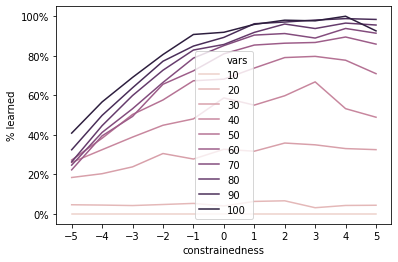

In [92]:
import matplotlib.ticker as mtick
g = sns.lineplot(x="constrainedness",y="learned", hue="vars", err_style=None, 
                data=dt_out, legend='full')
g.yaxis.set_major_formatter(mtick.PercentFormatter(1))
g.set_xlabel('constrainedness')
g.set_ylabel('% learned')
g.set_xticks([x for x in range(-5,6)]);


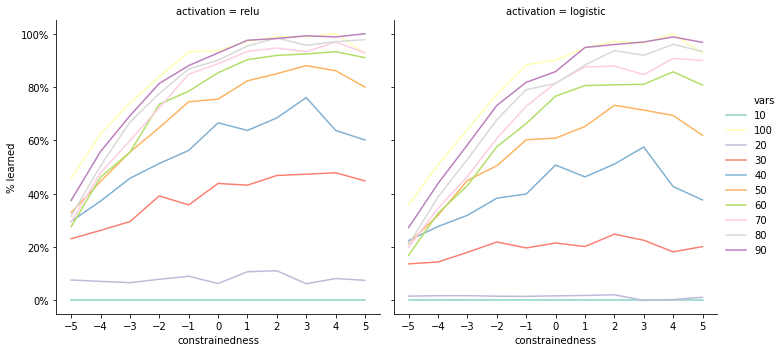

In [76]:
import matplotlib.ticker as mtick
grid = sns.relplot(x="constrainedness",y="learned", hue="vars", 
                   err_style=None, col="activation", legend="full",
                   palette="Set3",
                   kind="line", data=dt_out)

for ax in grid.axes.flat:
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
  ax.xaxis.set_ticks([x for x in range(-5,6)]);

grid.set_xlabels('constrainedness')
grid.set_ylabels('% learned');


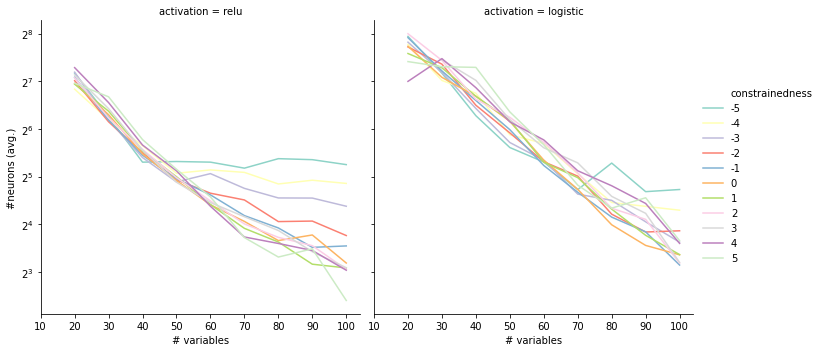

In [97]:
import matplotlib.ticker as mtick
dt_out['nvars'] = dt_out['vars'].astype('int64')

grid = sns.relplot(x="nvars",y="mean_neurons", hue="constrainedness", 
                   err_style=None, col="activation", 
                   palette="Set3", legend="full",
                   kind="line", data=dt_out)

for ax in grid.axes.flat:
  # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
  ax.set_yscale('log', basey=2)
  ax.xaxis.set_ticks([x for x in range(10,101,10)]);

grid.set_xlabels('# variables')
grid.set_ylabels('#neurons (avg.)');


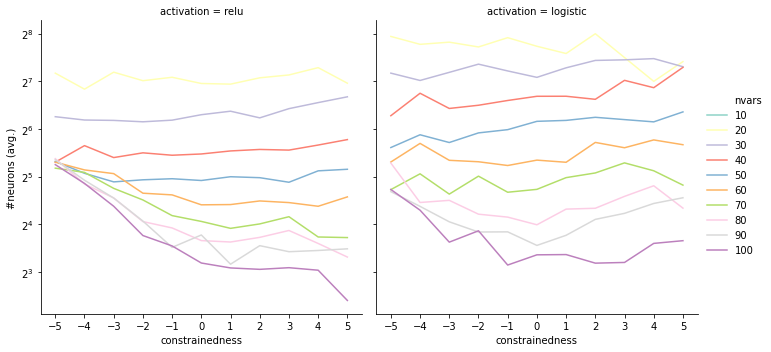

In [106]:
import matplotlib.ticker as mtick
dt_out['nvars'] = dt_out['vars'].astype('int64')

grid = sns.relplot(x="constrainedness",y="mean_neurons", hue="nvars", 
                   err_style=None, col="activation", 
                   palette="Set3", legend="full",
                   kind="line", data=dt_out)

for ax in grid.axes.flat:
  # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
  ax.set_yscale('log', basey=2)
  ax.xaxis.set_ticks([x for x in range(-5,6)]);
  # ax.yaxis.set_ticks([2**y for y in range(0,9)])

grid.set_xlabels('constrainedness')
grid.set_ylabels('#neurons (avg.)');

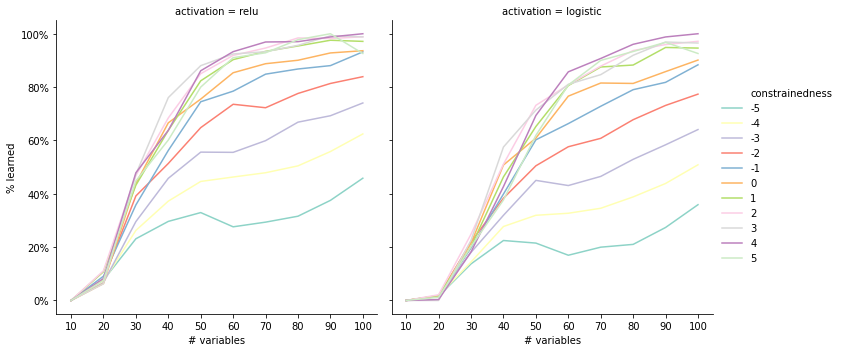

In [98]:
import matplotlib.ticker as mtick
dt_out['nvars'] = dt_out['vars'].astype('int64')

grid = sns.relplot(x="nvars",y="learned", hue="constrainedness", 
                   err_style=None, col="activation", 
                   palette="Set3", legend="full",
                   kind="line", data=dt_out)

for ax in grid.axes.flat:
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
  ax.xaxis.set_ticks([x for x in range(10,101,10)]);

grid.set_xlabels('# variables')
grid.set_ylabels('% learned');

## The problem is with multiple plots
Each will have a different number of instances (see code below), hence different y scales. I want the y axis in %

In [ ]:
import re
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
import numpy as np

def dir_string_ratio(dir_str):
    """
    Extracts the ratio on a directory string.
    Useful for sorting in increasing difficulty
    """
    pattern = re.compile(r"r(\d\.\d+)\.csv")
    return float(pattern.search(dir_str).group(1))

def plot_num_neurons(basedir, num_vars, activation):

    for f in sorted(glob(f'{basedir}/neurons_{activation}_v{num_vars}_*.csv'), key=dir_string_ratio):
        df = pd.read_csv(f)
        #df = df[df.sampler == 'unigen']  # gets only instances with 40+ solutions
        grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
        df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                                     sort=False, 
                                                     as_index=False).last()['#neurons'].value_counts(
                                                         normalize=True,
                                                         sort=False)
        idx = np.argsort(df2.index)
        x = df2.index[idx]
        y = df2.values[idx]                                             

        plt.figure()
        #sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
        #ax = sns.lineplot(x=x,y=y)
        ax = sns.barplot(x=x,y=y)
        plt.suptitle(f'{os.path.basename(f)}, {len(grouped_df)} instances')
        ax.set_ylim([0,1])
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        #ax.set_xlim([0,515])
        ax
        #plt.show()
        #plt.savefig(f'/tmp/{g}_freq.pdf')



In [ ]:
plot_num_neurons('/content/drive/My Drive/UFRGS/Learnability/relu/', 80, 'relu')